Single qubit state: Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.70710678]]
Bell state: Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]


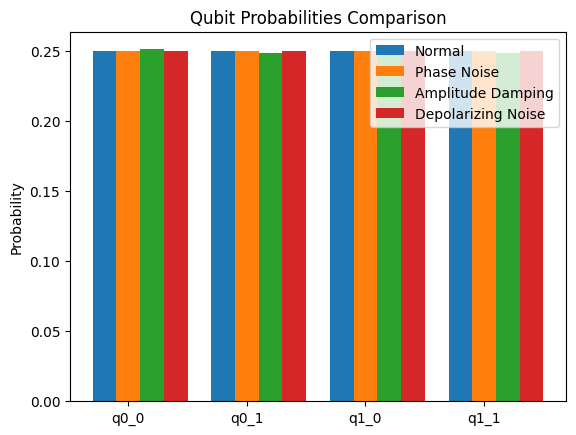

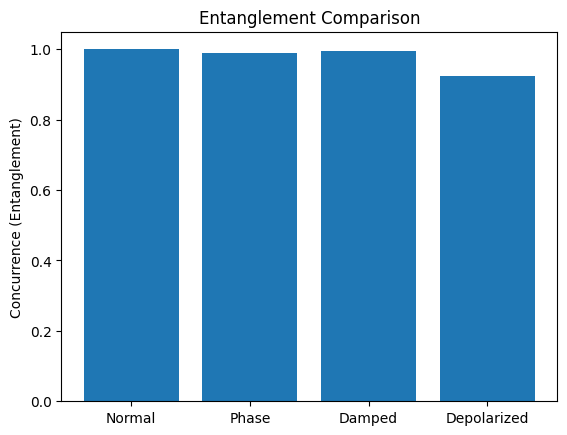

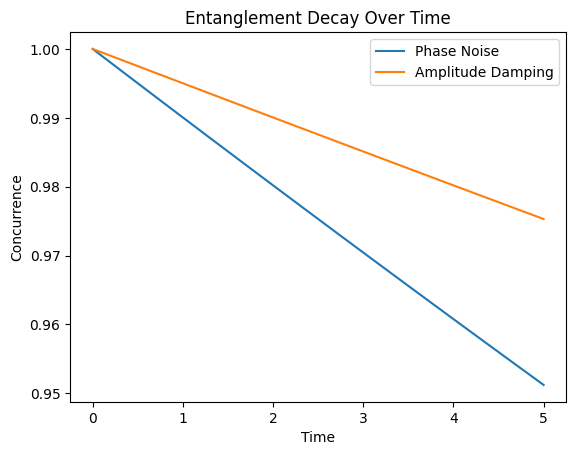

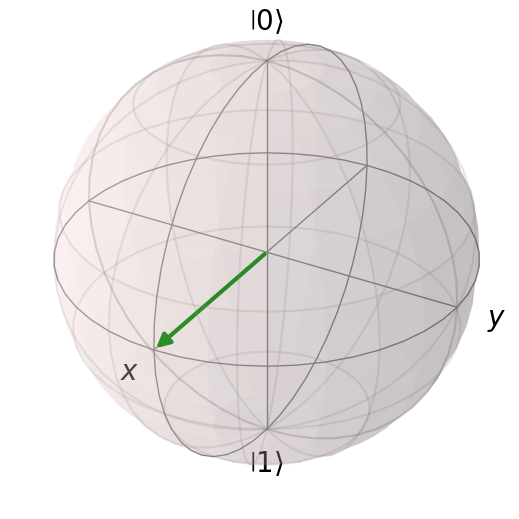

All CSV files saved. Project complete.


In [2]:
# ===============================================
# Quantum Simulation Project – Single Powerful Notebook
# ===============================================

# -------------------------------
# 1. Import Libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import (basis, tensor, ket2dm, fidelity, concurrence,
                   destroy, sigmax, sigmay, sigmaz, qeye, mesolve, Bloch)

# -------------------------------
# 2. Initialize Qubits
# -------------------------------

def create_single_qubit(state="plus"):
    if state == "zero":
        return basis(2,0)
    elif state == "one":
        return basis(2,1)
    elif state == "plus":
        return (basis(2,0) + basis(2,1)).unit()
    elif state == "minus":
        return (basis(2,0) - basis(2,1)).unit()

def create_bell_pair():
    q0 = basis(2,0)
    q1 = basis(2,1)
    bell = (tensor(q0,q0) + tensor(q1,q1)).unit()
    return bell

# Normal condition (no noise)
single_qubit = create_single_qubit("plus")
bell_state = create_bell_pair()
bell_density = ket2dm(bell_state)

print("Single qubit state:", single_qubit)
print("Bell state:", bell_state)

# -------------------------------
# 3. Noise Models
# -------------------------------

def apply_phase_noise(rho, gamma=0.1, tlist=[0,1]):
    sz1 = tensor(sigmaz(), qeye(2))
    sz2 = tensor(qeye(2), sigmaz())
    L = [gamma*sz1, gamma*sz2]
    result = mesolve(H=0*rho, rho0=rho, tlist=tlist, c_ops=L)
    return result.states[-1]

def apply_amplitude_damping(rho, gamma=0.1, tlist=[0,1]):
    c_ops = [gamma*tensor(destroy(2), qeye(2)), gamma*tensor(qeye(2), destroy(2))]
    result = mesolve(H=0*rho, rho0=rho, tlist=tlist, c_ops=c_ops)
    return result.states[-1]

def apply_depolarizing_noise(rho, p=0.1):
    I = qeye(2)
    return (1-p)*rho + (p/4)*(tensor(I,I))

# -------------------------------
# 4. Measurements
# -------------------------------

def compute_probabilities(rho):
    rho_q0 = rho.ptrace(0)
    rho_q1 = rho.ptrace(1)
    return {
        "q0_0": (rho_q0*rho_q0.dag()).diag()[0].real,
        "q0_1": (rho_q0*rho_q0.dag()).diag()[1].real,
        "q1_0": (rho_q1*rho_q1.dag()).diag()[0].real,
        "q1_1": (rho_q1*rho_q1.dag()).diag()[1].real
    }

def compute_fidelity(rho, rho_target):
    return fidelity(rho, rho_target)

def compute_entanglement(rho):
    return concurrence(rho)

# -------------------------------
# 5. Apply Noise & Compare
# -------------------------------

# Apply noises
rho_phase = apply_phase_noise(bell_density, gamma=0.05)
rho_damped = apply_amplitude_damping(bell_density, gamma=0.05)
rho_depolarized = apply_depolarizing_noise(bell_density, p=0.05)

# Measure
prob_normal = compute_probabilities(bell_density)
prob_phase = compute_probabilities(rho_phase)
prob_damped = compute_probabilities(rho_damped)
prob_depol = compute_probabilities(rho_depolarized)

fidelity_phase = compute_fidelity(rho_phase, bell_density)
fidelity_damped = compute_fidelity(rho_damped, bell_density)
fidelity_depol = compute_fidelity(rho_depolarized, bell_density)

ent_normal = compute_entanglement(bell_density)
ent_phase = compute_entanglement(rho_phase)
ent_damped = compute_entanglement(rho_damped)
ent_depol = compute_entanglement(rho_depolarized)

# -------------------------------
# 6. Visualization
# -------------------------------

# Probabilities bar plots
def plot_probabilities(*prob_dicts, labels=None, title="Qubit Probabilities"):
    x = np.arange(len(prob_dicts[0]))
    width = 0.2
    fig, ax = plt.subplots()
    for i, prob in enumerate(prob_dicts):
        ax.bar(x + i*width, list(prob.values()), width, label=labels[i])
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(prob_dicts[0].keys()))
    ax.set_ylabel("Probability")
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_probabilities(prob_normal, prob_phase, prob_damped, prob_depol,
                   labels=["Normal","Phase Noise","Amplitude Damping","Depolarizing Noise"],
                   title="Qubit Probabilities Comparison")

# Entanglement comparison
plt.bar(["Normal","Phase","Damped","Depolarized"], [ent_normal, ent_phase, ent_damped, ent_depol])
plt.ylabel("Concurrence (Entanglement)")
plt.title("Entanglement Comparison")
plt.show()

# -------------------------------
# 7. Time Evolution & Decoherence
# -------------------------------

tlist = np.linspace(0, 5, 50)

# Phase noise evolution
sz1 = tensor(sigmaz(), qeye(2))
sz2 = tensor(qeye(2), sigmaz())
L_phase = [0.05*sz1, 0.05*sz2]
evolution_phase = mesolve(H=0*bell_density, rho0=bell_density, tlist=tlist, c_ops=L_phase)
states_phase = evolution_phase.states

# Amplitude damping evolution
c_ops_damp = [0.05*tensor(destroy(2), qeye(2)), 0.05*tensor(qeye(2), destroy(2))]
evolution_damped = mesolve(H=0*bell_density, rho0=bell_density, tlist=tlist, c_ops=c_ops_damp)
states_damped = evolution_damped.states

# Entanglement decay
ent_phase_t = [concurrence(r) for r in states_phase]
ent_damped_t = [concurrence(r) for r in states_damped]

plt.plot(tlist, ent_phase_t, label="Phase Noise")
plt.plot(tlist, ent_damped_t, label="Amplitude Damping")
plt.xlabel("Time")
plt.ylabel("Concurrence")
plt.title("Entanglement Decay Over Time")
plt.legend()
plt.show()

# -------------------------------
# 8. Bloch Sphere Visualization for single qubit
# -------------------------------

b = Bloch()
b.add_states([single_qubit])
b.make_sphere()
b.title = "Single Qubit on Bloch Sphere"
b.show()

# -------------------------------
# 9. Save CSV files
# -------------------------------
pd.DataFrame([prob_normal]).to_csv("probabilities_normal.csv", index=False)
pd.DataFrame([prob_phase]).to_csv("probabilities_phase.csv", index=False)
pd.DataFrame([prob_damped]).to_csv("probabilities_damped.csv", index=False)
pd.DataFrame([prob_depol]).to_csv("probabilities_depolarized.csv", index=False)
pd.DataFrame([{"fidelity_phase": fidelity_phase, "fidelity_damped": fidelity_damped, "fidelity_depol": fidelity_depol}]).to_csv("fidelity.csv", index=False)
pd.DataFrame([{"ent_normal": ent_normal, "ent_phase": ent_phase, "ent_damped": ent_damped, "ent_depol": ent_depol}]).to_csv("entanglement.csv", index=False)

print("All CSV files saved. Project complete.")
